## Imports 

In [1]:
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import yaml
import os

from PIL import Image
import cv2

import utils
import trainModel


import segmentation_models as sm
from segmentation_models import get_preprocessing
from tensorflow.python.keras.models import load_model
import tensorflow as tf
import albumentations as album

Segmentation Models: using `keras` framework.


## Data

The next cell in this notebook contains relevant paths and options for the execution of the notebook.

`dataset_path`: string denoting the path of the dataset with entire tiffs
`tiles_path`: string denoting the path of the dataset with tiled images

`exp_dir`: path to the directory with experiments

`network`: name of the network used in the experiment. For Unet with pretrained encoder the network is named after the encoder

`experiment`: name of the experiment. See experiment folder of names

`encoder_flag`: boolean, if the network is with a pretrained encoder or not.

In [13]:
dataset_path = './Dataset/tiff/'
tiles_path = './AugmentedDataset/test'

exp_dir = './../Experiments/'
network = 'resnet50'
experiment = 'shuffle-lr'

encoder_flag = True

current = os.path.join(network, experiment)

In [14]:
log_df = pd.read_csv(os.path.join(exp_dir, current, 'log.csv'))

if encoder_flag:
    with open(os.path.join(exp_dir, current,'.hydra/config.yaml')) as f:
        config = yaml.load(f, Loader=yaml.loader.SafeLoader)
        print(config)
    
experiments_df = pd.read_csv(os.path.join(exp_dir, 'experiments.csv'))
experiments_df

#log_df.columns

{'paths': {'train': {'images': './AugmentedDataset/train/images/', 'labels': './AugmentedDataset/train/labels/'}, 'val': {'images': './AugmentedDataset/val/images/', 'labels': './AugmentedDataset/val/labels/'}, 'test': {'images': './AugmentedDataset/test/images/', 'labels': './AugmentedDataset/test/labels/'}, 'model': './Models/best_model.h5'}, 'model': {'backbone': 'resnet50', 'encoder_weights': 'imagenet', 'encoder_freeze': False, 'decoder_filters': [256, 128, 64, 32, 16]}, 'training': {'imageSize': [256, 256, 3], 'lr': 8e-05, 'batchSize': 16, 'epochs': 60, 'load_model': False}, 'outputs': {'model': 'best_model.h5', 'log': 'log.csv', 'modelSummary': 'modelSummary.txt'}}


,Network,Name,Decoder,Trainable_weights,Batch_size,lr,train_IoU,train_loss,train_epoch,val_IoU,val_loss,val_epoch,test_IoU,test_loss
0,Inceptionv3,256-16,256-16,True,16,0.00010,0.8915,0.1005,23,0.61560,0.2369,12,0.6117,0.2425
1,Inceptionv3,512-16,512-16,True,16,0.00010,0.8198,0.1001,29,0.61790,0.2378,12,0.6133,0.2411
2,Inceptionresnetv2,basic,256-16,True,16,0.00010,0.8228,0.0987,29,0.61950,0.2365,11,0.6155,0.2397
3,vgg16,batchSize_16,256-16,True,16,0.00010,0.7934,0.1163,29,0.61900,0.2371,9,0.6160,0.2393
4,vgg16,batchSize_32,256-16,True,32,0.00010,0.8052,0.1090,29,0.61120,0.2423,14,0.6102,0.2431
5,resnet18,trainable,256-16,True,16,0.00010,0.7958,0.1151,42,0.60470,0.2479,10,0.6025,0.2498
6,resnet18,frozen,256-16,False,16,0.00010,0.7155,0.1671,34,0.56420,0.2804,7,0.5594,0.2845
7,resnet34,trainable-false,256-16,False,16,0.00010,0.7122,0.1694,34,0.56970,0.2758,7,0.5658,0.2794
8,resnet50,trainable-false,256-16,False,16,0.00010,0.7371,0.1526,44,0.58120,0.2665,5,0.5771,0.2702
9,resnet50,bs8-lr1,256-16,True,8,0.00010,0.7379,0.1527,42,0.61970,0.2379,10,0.6167,0.2386


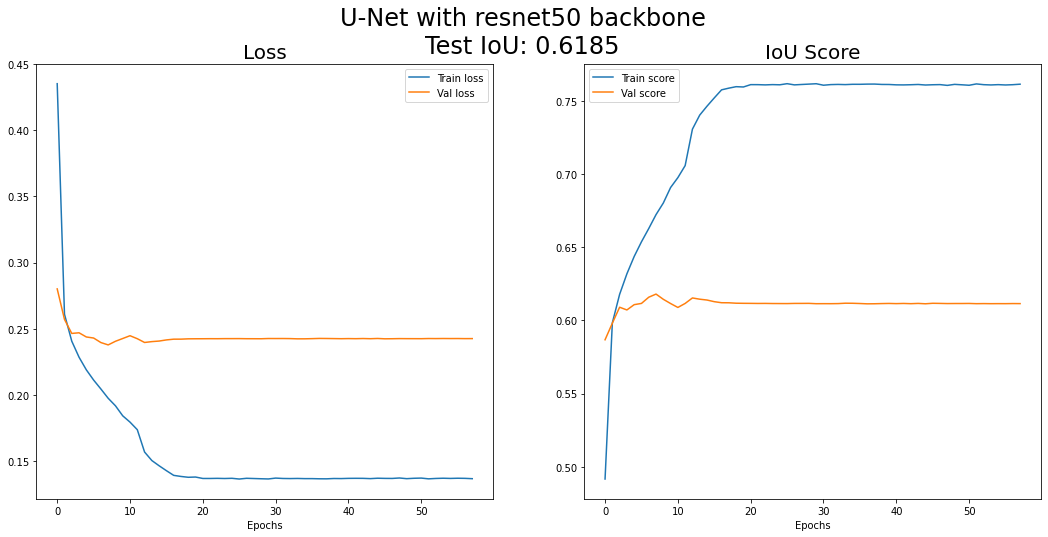

In [15]:
figure, axes= plt.subplots(1,2, figsize=(18,8))

log_df.plot(x='epoch', y=['loss','val_loss'], xlabel='Epochs', ax=axes[0])
axes[0].set_title('Loss', fontsize=20)
axes[0].legend(['Train loss', 'Val loss'])

test_score = experiments_df[(experiments_df['Network']==network) & (experiments_df['Name']==experiment)]
test_score = test_score['test_IoU'].item()



log_df.plot(x='epoch', y=['iou_score','val_iou_score'], xlabel='Epochs', ax=axes[1])
axes[1].set_title('IoU Score', fontsize=20)
axes[1].legend(['Train score', 'Val score'])
if encoder_flag:
    figure.suptitle(f"U-Net with {config['model']['backbone']} backbone\nTest IoU: {test_score}", fontsize=24)
else:
    figure.suptitle(f"U-Net with 256 channels\nTest IoU: {test_score}", fontsize=24)
#figure.savefig(os.path.join(exp_dir, current, 'graph.png'),facecolor='white')
plt.show()

## Prediction comparison

In [16]:
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

In [17]:
model_path = os.path.join(exp_dir, current, 'best_model.h5')

sm.set_framework('tf.keras')
if encoder_flag:
    model = load_model(
        model_path, 
        custom_objects={'dice_loss': sm.losses.dice_loss, 'iou_score': sm.metrics.iou_score})

    opt = tf.keras.optimizers.Adam(learning_rate=config['training']['lr'])

    model.compile(
        optimizer=opt,
        loss=sm.losses.dice_loss,
        metrics=[sm.metrics.IOUScore(threshold=0.5)])
    
    preprocessInput = get_preprocessing(network)
    
else:
    model = load_model(
        model_path, 
        custom_objects={'soft_dice_loss': utils.soft_dice_loss, 'iou_coef': utils.iou_coef})

    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

    model.compile(
        optimizer=opt,
        loss=sm.losses.dice_loss,
        metrics=[sm.metrics.IOUScore(threshold=0.5)])
    
    preprocessInput = None


In [18]:
tiles = ['10228660_15_5.png', '10378735_15_1.png', '10828750_15_0.png']

#tiles = np.random.choice(os.listdir(os.path.join(tiles_dir, 'images')), 3)

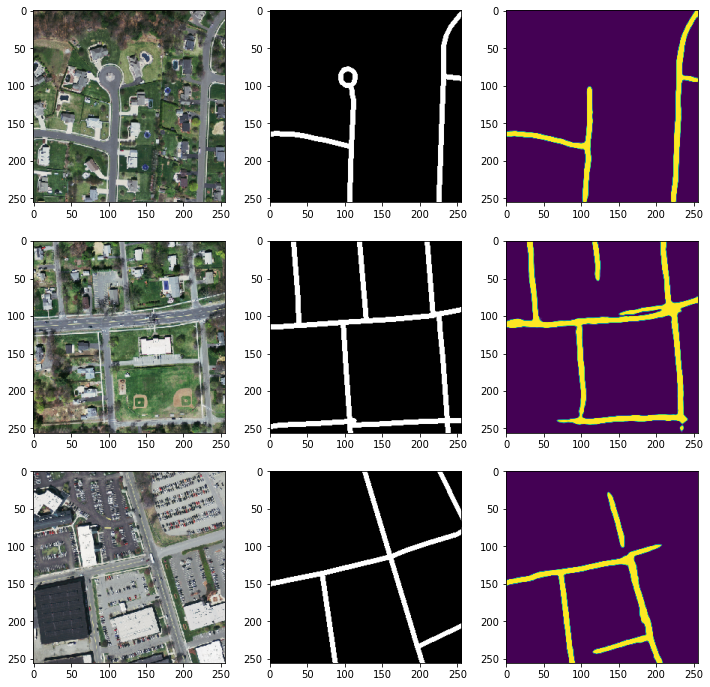

In [19]:
fig, axes = plt.subplots(3,3, figsize=(12,12))
for i, tile in enumerate(tiles):
    axes[i,0].imshow(Image.open(os.path.join(tiles_path, 'images', tile)))
    axes[i,1].imshow(Image.open(os.path.join(tiles_path, 'labels', tile)))
    
    image = tf.keras.preprocessing.image.img_to_array(
        Image.open(os.path.join(tiles_path, 'images', tile)))
    
    image = image if preprocessInput is None else preprocessInput(image)
    pred = model(np.expand_dims(image, axis=0))
    #pred = reverse_one_hot(np.squeeze(pred, axis=0))
    pred = tf.keras.preprocessing.image.array_to_img(np.squeeze(pred, axis=0))
    axes[i,2].imshow(pred)

0it [00:00, ?it/s]

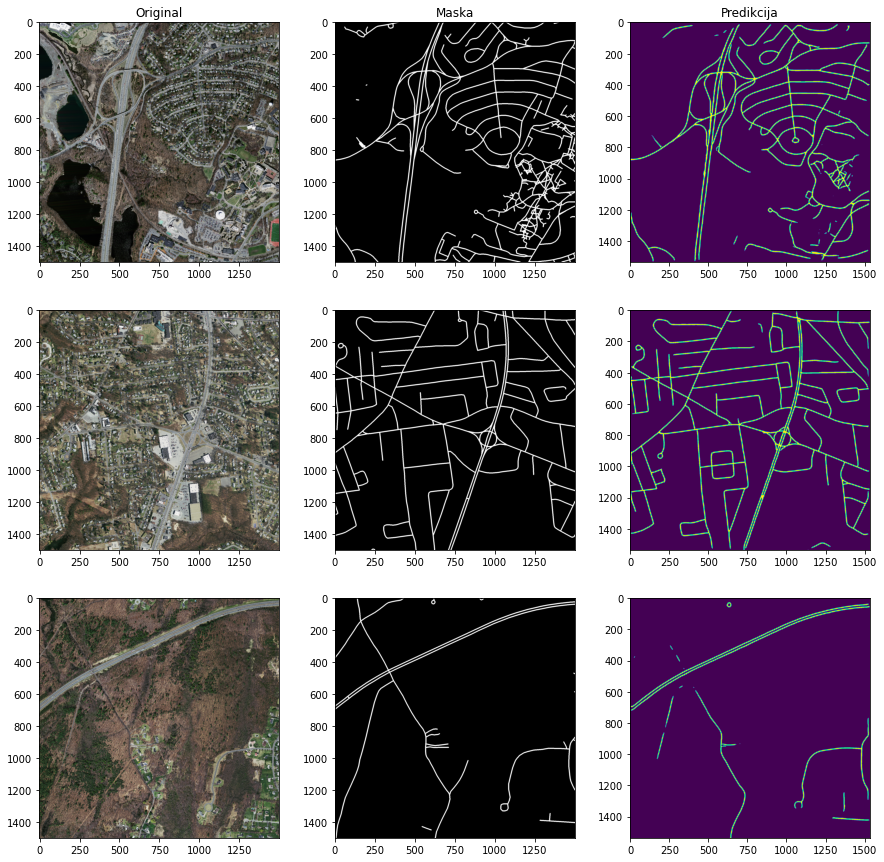

In [20]:
pad = album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0)

f, a = plt.subplots(3,3, figsize=(15,15))

for i, slide in tqdm(enumerate(['21929020_15', '11128840_15', '10378780_15'])):
    image_o = cv2.imread(os.path.join(dataset_path, 'images', slide + '.tiff'))
    mask_o = cv2.imread(os.path.join(dataset_path, 'labels', slide + '.tif'))

    processed = image_o if preprocessInput is None else preprocessInput(image_o)
    
    sample = pad(image = processed, mask=mask_o)
    image, mask = sample['image'], sample['mask']

    pred = model(np.expand_dims(image, axis=0))
    pred = tf.keras.preprocessing.image.array_to_img(np.squeeze(pred, axis=0))
    #pred = reverse_one_hot(np.squeeze(pred, axis=0))

    
    a[i,0].imshow(cv2.cvtColor(image_o, cv2.COLOR_BGR2RGB))
    a[0,0].set_title('Original')
    a[i,1].imshow(mask_o)
    a[0,1].set_title('Maska')
    a[i,2].imshow(pred)
    a[0,2].set_title('Predikcija')

a[0,0].set_title('Original')
a[0,1].set_title('Maska')
a[0,2].set_title('Predikcija')
plt.show()
#21929020_15 many dits+
#11278720_15 lake and perfect
#11128840_15 large intersection +
#10378780_15 dirt roads +

## Total Prediction

Preform prediction on the entire .tiff dataset. Uses already defined `dataset_path` parameter. 

`output_path` needs to be specified

In [25]:
output_path = './Dataset/tiff/preds'
if not os.path.exists(output_path):
    os.mkdir(output_path)

for image_name in tqdm(os.listdir(os.path.join(dataset_path, 'images'))):
    pad = album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0)

    image_o = cv2.imread(os.path.join(dataset_path, 'images', image_name))
    mask_o = cv2.imread(os.path.join(dataset_path, 'labels', image_name))
    
    sample = pad(image = preprocessInput(image_o), mask=mask_o)
    image, mask = sample['image'], sample['mask']

    pred = model(np.expand_dims(image, axis=0))
    pred = tf.keras.preprocessing.image.array_to_img(np.squeeze(pred, axis=0))
    
    #pred.save(os.path.join('/home/sreten/Desktop/preds/', image_name))


  0%|          | 0/867 [00:00<?, ?it/s]

KeyboardInterrupt: 